# Clustering Crypto

In [23]:
# Initial imports
import requests
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.pandas
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from pathlib import Path

### Fetching Cryptocurrency Data

In [18]:
# Use the following endpoint to fetch json data
url = "https://min-api.cryptocompare.com/data/all/coinlist"

In [ ]:
# Create a DataFrame 
crypto_df = pd.DataFrame

In [33]:
# Alternatively, use the provided csv file:
# file_path = Path("Resources/crypto_data.csv")
file_path = Path("Resources/crypto_data.csv")
crypto_df = pd.read_csv(file_path)
print(crypto_df.shape)
crypto_df.head()
# Create a DataFrame

(1252, 7)


,Unnamed: 0,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
0,42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
1,365,365Coin,X11,True,PoW/PoS,NaN,2300000000
2,404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
3,611,SixEleven,SHA-256,True,PoW,NaN,611000
4,808,808,SHA-256,True,PoW/PoS,0.000000e+00,0


### Data Preprocessing

In [34]:
# Keep only necessary columns:
# 'CoinName','Algorithm','IsTrading','ProofType','TotalCoinsMined','TotalCoinSupply'
crypto_df.drop(columns=['Unnamed: 0'], inplace=True)

In [35]:
crypto_df.head()

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
0,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
1,365Coin,X11,True,PoW/PoS,NaN,2300000000
2,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
3,SixEleven,SHA-256,True,PoW,NaN,611000
4,808,SHA-256,True,PoW/PoS,0.000000e+00,0


In [36]:
# Keep only cryptocurrencies that are trading
non_trading = crypto_df[crypto_df["IsTrading"] == False].index
crypto_df.drop(non_trading , inplace=True)

In [37]:
crypto_df.head()

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
0,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
1,365Coin,X11,True,PoW/PoS,NaN,2300000000
2,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
3,SixEleven,SHA-256,True,PoW,NaN,611000
4,808,SHA-256,True,PoW/PoS,0.000000e+00,0


In [38]:
# Keep only cryptocurrencies with a working algorithm
crypto_df= crypto_df[crypto_df['Algorithm']!= 'N/A']

In [40]:
crypto_df.head()

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
0,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
1,365Coin,X11,True,PoW/PoS,NaN,2300000000
2,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
3,SixEleven,SHA-256,True,PoW,NaN,611000
4,808,SHA-256,True,PoW/PoS,0.000000e+00,0


In [41]:
# Remove the "IsTrading" column
crypto_df.drop(columns=['IsTrading'], inplace=True)

In [42]:
crypto_df.head()

,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
0,42 Coin,Scrypt,PoW/PoS,4.199995e+01,42
1,365Coin,X11,PoW/PoS,NaN,2300000000
2,404Coin,Scrypt,PoW/PoS,1.055185e+09,532000000
3,SixEleven,SHA-256,PoW,NaN,611000
4,808,SHA-256,PoW/PoS,0.000000e+00,0


In [43]:
# Remove rows with at least 1 null value
crypto_df.dropna(inplace=True)

In [45]:
# Remove rows with cryptocurrencies having no coins mined
crypto_df = crypto_df[crypto_df['TotalCoinsMined']>0]

In [47]:
# Drop rows where there are 'N/A' text values
crypto_df = crypto_df[crypto_df!='N/A']

In [49]:
# Store the 'CoinName'column in its own DataFrame prior to dropping it from crypto_df
coin_name = pd.DataFrame(crypto_df['CoinName'])
coin_name

,CoinName
0,42 Coin
2,404Coin
5,EliteCoin
7,Bitcoin
8,Ethereum
...,...
1238,ZEPHYR
1242,Gapcoin
1245,Beldex
1246,Horizen


In [50]:
# Drop the 'CoinName' column since it's not going to be used on the clustering algorithm
crypto_df.drop(columns='CoinName', inplace=True)
crypto_df.head()

,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
0,Scrypt,PoW/PoS,4.199995e+01,42
2,Scrypt,PoW/PoS,1.055185e+09,532000000
5,X13,PoW/PoS,2.927942e+10,314159265359
7,SHA-256,PoW,1.792718e+07,21000000
8,Ethash,PoW,1.076842e+08,0


In [54]:
# Create dummy variables for text features
crypto_dummy = pd.get_dummies(crypto_df, columns = ['Algorithm', 'ProofType'])
crypto_dummy.head()

,TotalCoinsMined,TotalCoinSupply,Algorithm_1GB AES Pattern Search,Algorithm_536,Algorithm_Argon2d,Algorithm_BLAKE256,Algorithm_Blake,Algorithm_Blake2S,Algorithm_Blake2b,Algorithm_C11,...,ProofType_PoW/PoS,ProofType_PoW/PoS,ProofType_PoW/PoW,ProofType_PoW/nPoS,ProofType_Pos,ProofType_Proof of Authority,ProofType_Proof of Trust,ProofType_TPoS,ProofType_Zero-Knowledge Proof,ProofType_dPoW/PoW
0,4.199995e+01,42,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,1.055185e+09,532000000,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5,2.927942e+10,314159265359,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
7,1.792718e+07,21000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1.076842e+08,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
# Standardize data
crypto_scaled = StandardScaler().fit_transform(crypto_dummy)
crypto_scaled

array([[-0.11710817, -0.1528703 , -0.0433963 , ..., -0.0433963 ,
        -0.0433963 , -0.0433963 ],
       [-0.09396955, -0.145009  , -0.0433963 , ..., -0.0433963 ,
        -0.0433963 , -0.0433963 ],
       [ 0.52494561,  4.48942416, -0.0433963 , ..., -0.0433963 ,
        -0.0433963 , -0.0433963 ],
       ...,
       [-0.09561336, -0.13217937, -0.0433963 , ..., -0.0433963 ,
        -0.0433963 , -0.0433963 ],
       [-0.11694817, -0.15255998, -0.0433963 , ..., -0.0433963 ,
        -0.0433963 , -0.0433963 ],
       [-0.11710536, -0.15285552, -0.0433963 , ..., -0.0433963 ,
        -0.0433963 , -0.0433963 ]])

### Reducing Dimensions Using PCA

In [57]:
# Use PCA to reduce dimensions to 3 principal components
pca = PCA(n_components=3)
crypto_pca = pca.fit_transform(crypto_scaled)

In [58]:
# Create a DataFrame with the principal components data
crypto_pca_df = pd.DataFrame(data = crypto_pca, columns=['PC1', 'PC2', 'PC3'])
crypto_pca_df.head()

,PC1,PC2,PC3
0,-0.336437,1.024457,-0.580746
1,-0.319781,1.024816,-0.581225
2,2.307323,1.659182,-0.675693
3,-0.144831,-1.312376,0.182686
4,-0.157591,-2.005180,0.340887


### Clustering Crytocurrencies Using K-Means

#### Find the Best Value for `k` Using the Elbow Curve

In [59]:
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(crypto_pca_df)
    inertia.append(km.inertia_) 

# Create the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.hvplot.line(x="k", y="inertia", xticks=k, title="Elbow Curve")

C:\Users\16155\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


:Curve   [k]   (inertia)

Running K-Means with `k=<your best value for k here>`

In [66]:
# Initialize the K-Means model
km = KMeans(n_clusters=4, random_state=0)
# Fit the model
km.fit(crypto_pca_df)
# Predict clusters
prediction = km.predict(crypto_pca_df)
# Create a new DataFrame including predicted clusters and cryptocurrencies features
crypto_pca_df['Class'] = km.labels_
crypto_pca_df.index = crypto_df.index

In [67]:
clustered_crypto_df = pd.concat([crypto_df, crypto_pca_df, coin_name], axis=1)
clustered_crypto_df.head()

,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply,PC1,PC2,PC3,class,Class,CoinName
0,Scrypt,PoW/PoS,4.199995e+01,42,-0.336437,1.024457,-0.580746,0,0,42 Coin
2,Scrypt,PoW/PoS,1.055185e+09,532000000,-0.319781,1.024816,-0.581225,0,0,404Coin
5,X13,PoW/PoS,2.927942e+10,314159265359,2.307323,1.659182,-0.675693,0,0,EliteCoin
7,SHA-256,PoW,1.792718e+07,21000000,-0.144831,-1.312376,0.182686,3,1,Bitcoin
8,Ethash,PoW,1.076842e+08,0,-0.157591,-2.005180,0.340887,3,1,Ethereum


### Visualizing Results

#### 3D-Scatter with Clusters

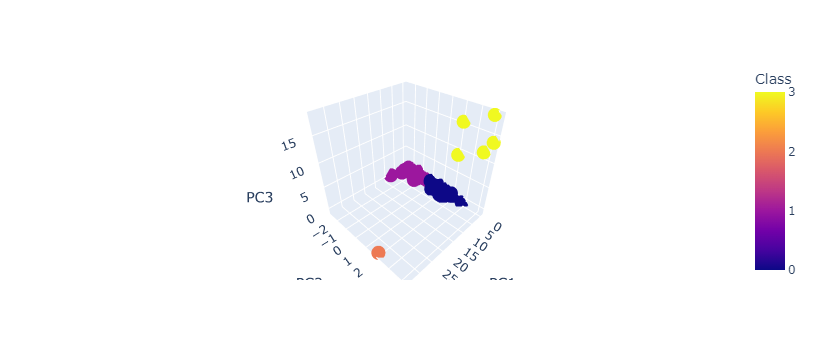

In [68]:
# Create a 3D-Scatter with the PCA data and the clusters
fig = px.scatter_3d(clustered_crypto_df, x="PC1", y="PC2", z="PC3", hover_name="CoinName", hover_data=["Algorithm"], color="Class",)
fig.show()

#### Table of Tradable Cryptocurrencies

In [69]:
# Table with tradable cryptos
clustered_crypto_df.hvplot.table(columns=['Algorithm', 'ProofType', 'TotalCoinsMined', 'TotalCoinSupply', 'Class', 'CoinName'])

:Table   [Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply,Class,CoinName]

In [78]:
# Print the total number of tradable cryptocurrencies
total_tradeable_cryptos = clustered_crypto_df.count()
print(total_tradeable_cryptos - 1)

Algorithm          531
ProofType          531
TotalCoinsMined    531
TotalCoinSupply    531
PC1                531
PC2                531
PC3                531
class              531
Class              531
CoinName           531
dtype: int64


#### Scatter Plot with Tradable Cryptocurrencies

In [74]:
# Scale data to create the scatter plot
clustered_crypto_df['TotalCoinSupply'] = clustered_crypto_df['TotalCoinSupply'].astype("float")
scaled_crypto_df = clustered_crypto_df[['TotalCoinSupply', 'TotalCoinsMined']]
scaled_crypto_df = StandardScaler().fit_transform(scaled_crypto_df)
scaled_crypto_df = pd.DataFrame(scaled_crypto_df, columns=['TotalCoinSupply', 'TotalCoinsMined'])

In [75]:
# Plot the scatter with x="TotalCoinsMined" and y="TotalCoinSupply"
scaled_crypto_df.hvplot.scatter(x="TotalCoinsMined", y="TotalCoinSupply")

:Scatter   [TotalCoinsMined]   (TotalCoinSupply)